## HongKong Property Index Forecasting

Today I am going to use multivariate information to predict HongKong Property index. The data I am using,"HongKong_property_index_combined_2022.xlsx", is downloaded from the Global Financial Data base and contains   
monthly information on the Hong Kong Hang Seng property price index (HKPI, column 
B), Hong Kong consumer price index (CPI, column C), Hong Kong 5-year government 
bond yields (column D), the Hong Kong unemployment rate (column E) and the Hong 
Kong-US dollar exchange rate (column F)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.arima_model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.api import VAR
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector as SFS
import statsmodels.api as sm

In [21]:
df = pd.read_excel("C:/VSProject/data/HongKong_property_index_combined_2022 - Copy.xlsx")
df.index = pd.to_datetime(df['Date'])

### ARIMA

In [22]:
# Compute the log first-difference of the property price index, i.e., ΔHKPIt = ln(HKPIt/HKPIt-1). 
# This is the variable I am interested in forecasting. 

df['HKPI'] = np.log(df['Hong Kong Property index']).diff(1)

df['infl']  = np.log(df['Hong Kong CPI']).diff(1)

df['5yr'] = np.log(df['Hong Kong 5-yr govt yield']).diff(1)

df['unrate'] = np.log(df['Hong Kong unemployment rate']).diff(1)

df['exrate'] = np.log(df['HK-US dollar exchange rate']).diff(1)

df = df[['HKPI','infl','5yr','unrate','exrate']].dropna(axis=0)

# model_df = df[['HKPI','infl','5yr','unrate','exrate']].dropna(axis=0)
# model_df
df.head()

,HKPI,infl,5yr,unrate,exrate
Date,,,,,
1994-10-31,0.014366,0.009434,0.037458,0.000000,0.000026
1994-11-30,-0.173580,0.005851,0.024214,0.000000,0.000893
1994-12-31,-0.068029,0.008135,0.007151,-0.191055,0.000401
1995-01-31,-0.099165,0.005770,0.019989,0.000000,-0.000259
1995-02-28,0.166856,0.006881,-0.064927,0.000000,-0.000504


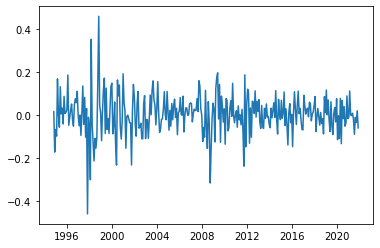

In [8]:
plt.plot(df.index,df['HKPI'])
plt.show()

I can tell from its graph that this series is predictable since it volatiles very frequently. So we plan to estimate an ARIMA model. In order to choose the best lag for ARIMA model, I need to use AIC and BIC scores.

In [23]:
def AIC_PDQ(df,ar,ii,ma): 

# Define the p, d and q parameters to take any user defined value. We need to be careful with integration order, cannot be 0.    p = range(0,ar)
    p = range(0,ar)
    d = range(0,ii)
    q = range(0, ma)

# Auto-Regressive (p) -> Number of autoregressive terms.
# Integrated (d) -> Number of nonseasonal differences needed for stationarity.
# Moving Average (q) -> Number of lagged forecast errors in the prediction equation.
# Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
    ans = []
    for comb in pdq:
        try:
            mod = ARIMA(df,order=comb,freq='M')
            output = mod.fit()
            ans.append([comb, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, output.aic))
        except:
            continue

    ans_df = pd.DataFrame(ans,columns=['pdq', 'aic'])
    return ans_df

In [24]:
def BIC_PDQ(df,ar,ii,ma): 

# Define the p, d and q parameters to take any user defined value. We need to be careful with integration order, cannot be 0.
    p = range(0,ar)
    d = range(0,ii)
    q = range(0, ma)

# Auto-Regressive (p) -> Number of autoregressive terms.
# Integrated (d) -> Number of nonseasonal differences needed for stationarity.
# Moving Average (q) -> Number of lagged forecast errors in the prediction equation.
# Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best BIC value
    ans = []
    for comb in pdq:
        try:
            mod = ARIMA(df,order=comb,freq='M')
            output = mod.fit()
            ans.append([comb, output.bic])
            print('ARIMA {} x {}12 : BIC Calculated ={}'.format(comb, output.bic))
        except:
            continue
            
    ans_df = pd.DataFrame(ans,columns=['pdq', 'bic'])
    return ans_df

In [25]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)

In [26]:
train, test = df['HKPI'][:-60], df['HKPI'][-60:]
AIC_scores = AIC_PDQ(train,6,1,6)
BIC_scores = BIC_PDQ(train,6,1,6)
AIC_BIC_scores = AIC_scores.merge(BIC_scores,on = 'pdq',how='outer')
AIC_BIC_scores = AIC_BIC_scores.iloc[1:,]
AIC_BIC_scores

C:\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\

,pdq,aic,bic
1,"(0, 0, 1)",-476.613877,-465.863388
2,"(0, 0, 2)",-475.313383,-460.979398
3,"(0, 0, 3)",-473.842257,-455.924775
4,"(0, 0, 4)",-472.877688,-451.376710
5,"(0, 0, 5)",-471.103375,-446.018901
6,"(1, 0, 0)",-476.575400,-465.824911
7,"(1, 0, 1)",-474.903854,-460.569869
8,"(1, 0, 2)",-481.526966,-463.609484
9,"(1, 0, 3)",-479.539732,-458.038754
10,"(1, 0, 4)",-470.988927,-445.904453


In [27]:
# Find models with lowest AIC and BIC criteria, corresponding to best statistical fit
minaic_pdq = AIC_BIC_scores.sort_values(by = 'aic').iloc[0][0]
minbic_pdq = AIC_BIC_scores.sort_values(by = 'bic').iloc[0][0]

print(f'The order for best AIC = {minaic_pdq} and the order for best BIC = {minbic_pdq}\n')

The order for best AIC = (1, 0, 2) and the order for best BIC = (0, 0, 1)



Now I use the lag of the best AIC to estimate an ARIMA model, which is the ARMA(1,2) model.

In [28]:
from numpy.linalg import LinAlgError
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
bestAICModelLags = minaic_pdq
predictions = []
history = [i for i in train]
# Estimate model chosen by AIC
for t in range(len(test)):
    modelEstimate=ARIMA(endog = history,
                      order=bestAICModelLags
                      #trend?
                      )
    try:
        fit_= modelEstimate.fit()
    except (ValueError, LinAlgError): pass
    
    forecasted_value = fit_.forecast()

    yhat = forecasted_value[0][0]
    predictions.append(yhat)
    obs = test.iloc[t]
    history.append(obs)

C:\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\

Now I could see how the ARMA(1,2) model performed. From the plot we see that it tends to predict the mean value. Also the Mean-squared error(MSE) is small, I need better model to capture the volatility of the HK property Index.

In [37]:
forecast_actual = pd.DataFrame(test)
forecast_actual['predicted'] = predictions
forecast_actual.columns = ['actual','predicted']
# forecast_actual

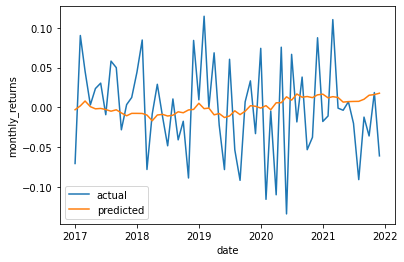

In [33]:
plt.plot(forecast_actual.index,forecast_actual['actual'])
plt.ylabel('monthly_returns')
plt.xlabel('date')
plt.plot(forecast_actual.index,forecast_actual['predicted'])
plt.legend(('actual','predicted'))
plt.show()

In [34]:
fit_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  325
Model:                     ARMA(1, 2)   Log Likelihood                 320.208
Method:                       css-mle   S.D. of innovations              0.090
Date:                Mon, 21 Feb 2022   AIC                           -630.416
Time:                        21:05:31   BIC                           -611.497
Sample:                             0   HQIC                          -622.866
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      4.770      0.000       0.002       0.004
ar.L1.y        0.9187      0.025     36.844      0.000       0.870       0.968
ma.L1.y       -0.9422      0.060    -15.680      0.000      -1.060      -0.824
ma.L2.y       -0.0578      0.059     -0.974      0.330      -0.174       0.058
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0885           +0.0000j            1.0885            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2          -17.3076           +0.0000j           17.3076            0.5000
-----------------------------------------------------------------------------
"""

In [35]:
# Define a function to calculate Mean Squared Error
def MSE(actual, pred):
    sse = [(a-p)**2 for a,p in zip(actual,pred)]
    return(np.mean(sse))

In [36]:
MSE(test,predictions)

0.0034711998311766096

In [59]:
df.head()

,Date,Hong Kong Property index,Hong Kong CPI,Hong Kong 5-yr govt yield,Hong Kong unemployment rate,HK-US dollar exchange rate,HKPI,infl
Date,,,,,,,,
1994-11-30,11/30/1994,14475.3994,69.683252,8.36,2.3,7.7344,-0.173580,0.005851
1994-12-31,12/31/1994,13523.3994,70.252427,8.42,1.9,7.7375,-0.068029,0.008135
1995-01-31,01/31/1995,12246.7002,70.658981,8.59,1.9,7.7355,-0.099165,0.005770
1995-02-28,02/28/1995,14470.5000,71.146845,8.05,1.9,7.7316,0.166856,0.006881
1995-03-31,03/31/1995,14532.7988,71.472087,7.58,2.6,7.7321,0.004296,0.004561


## Feature selection

One way to improve the performance of the model is to find if there exsits other variables that is useful useful for us to predict. Here we use Random Forest and LASSO regression to help us to check.

In [44]:
# First we to reconstruct the data
model_df = df[['HKPI','infl','5yr','unrate','exrate']].dropna(axis=0)
X = model_df.iloc[:, 1:]
# .reset_index(drop=True)
Y = model_df.loc[:,'HKPI']
# .reset_index(drop=True)
column_means = X.mean()
X = X.fillna(column_means)
print(X.shape,Y.shape)
    

(326, 4) (326,)


In [39]:
train_X = X[:6*len(X)//8]
train_Y = Y[:6*len(Y)//8]
val_X = X[6*len(X)//8:7*len(X)//8]
val_Y = Y[6*len(Y)//8:7*len(Y)//8]
test_X = X[7*len(X)//8:]
test_Y = Y[7*len(Y)//8:]

### Random Forest

In [40]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_X= scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)
val_X= scaler.fit_transform(val_X)

In [41]:
# tune hyperparameters based on the number of trees
n_estimators_tune = [10,20,30]

# run the hyperparameters selection in loop and sleect the best number of trees from the result
store_predictions = []
for i in n_estimators_tune:
    regressor = RandomForestRegressor(n_estimators = i, random_state = 42)
    regressor.fit(train_X, train_Y)
    train_pred = regressor.predict(train_X)
    val_pred = regressor.predict(val_X)
    train_rmse = MSE(train_Y,train_pred)
    val_rmse = MSE(val_Y,val_pred)    
    store_predictions.append([i,train_rmse,val_rmse])

store_predictions = pd.DataFrame(store_predictions,columns = ['Number of trees','RMSE train data','RMSE validation data'])
store_predictions

,Number of trees,RMSE train data,RMSE validation data
0,10,0.002207,0.017238
1,20,0.001859,0.014578
2,30,0.001831,0.013951


In [42]:
# define RF regressor with best number of trees
regressor = RandomForestRegressor(n_estimators = 10, random_state = 42)
  
# fit the regressor with x and y data
regressor.fit(train_X, train_Y)
regressor.score(train_X, train_Y)

0.7796210697568645

In [212]:
# extract feature importance from model
importance = regressor.feature_importances_

# summarize feature importance
feature_importance = []
for v in range(len(importance)):
    feature_importance.append((X.columns[v],importance[v]))
    
feature_importance = sorted(feature_importance, key = lambda x:(x[1]), reverse=True)
feature_importance = pd.DataFrame(feature_importance, columns = ['Feature','Importance'])
feature_importance

,Feature,Importance
0,unrate,0.279128
1,exrate,0.276660
2,5yr,0.250102
3,infl,0.194109


I could see that the new variable makes the prediction more accurate since it can capture the volatility.  

Text(0.5, 1.0, 'Random Forest Test data')

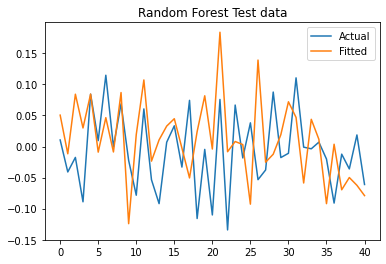

In [45]:
X_grid = np.arange(len(test_X))
X_grid = X_grid.reshape((len(X_grid), 1))
plt.plot(X_grid,test_Y)
#plt.xlabel('date')
plt.plot(X_grid,regressor.predict(test_X))
plt.legend(('Actual','Fitted'))
plt.title('Random Forest Test data')
# plt.savefig('Random Forest test')

### Lasso Regression

In [217]:
from sklearn.linear_model import Lasso
alpha_ = [0.000005,0.00001,0.00009]
store_predictions = []
for i in alpha_:
    reg = Lasso(alpha=i, max_iter=1000)
    res =reg.fit(train_X, train_Y)
    train_pred = res.predict(train_X)
    # val_pred = res.predict(val_X)
    train_rmse = MSE(train_Y,train_pred)
    # val_rmse = MSE(val_Y,val_pred)
    train_rsquared = round(res.score(train_X,train_Y)*100, 2)
    # val_rsquared = round(res.score(val_X,val_Y)*100, 2)
    store_predictions.append([i,train_rmse,train_rsquared
    # ,val_rmse,val_rsquared
    ])

store_predictions = pd.DataFrame(store_predictions,columns = ['Alpha','RMSE train data','R-Squared value train'
# ,'RMSE validation data','R-Squared value validation'
])
store_predictions

,Alpha,RMSE train data,R-Squared value train
0,0.000005,0.009802,2.14
1,0.000010,0.009802,2.14
2,0.000090,0.009804,2.12


In [218]:
reg = Lasso(alpha=0.000009, max_iter=10000)
res =reg.fit(train_X, train_Y)
pred = res.predict(test_X)

coef=res.coef_
# summarize feature importance
feature_importance = []
for v in range(len(coef)):
    feature_importance.append((X.columns[v],coef[v]))
    
feature_importance = sorted(feature_importance, key = lambda x:(x[1]), reverse=True)
feature_importance = pd.DataFrame(feature_importance, columns = ['Feature','Importance'])
feature_importance

,Feature,Importance
0,infl,0.003873
1,unrate,-0.006519
2,exrate,-0.010834
3,5yr,-0.148628


Lasso regresion also proves that this new variable is useful for our prediction.

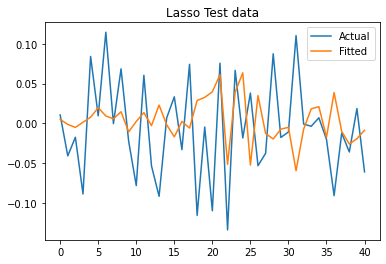

In [115]:
X_grid = np.arange(len(test_X))
X_grid = X_grid.reshape((len(X_grid), 1))
plt.plot(X_grid,test_Y)
#plt.xlabel('date')
plt.plot(X_grid,res.predict(test_X))
plt.legend(('Actual','Fitted'))
plt.title('Lasso Test data')
plt.savefig('Lasso Test')

### VAR

However,if we see the economic meaning of these variables, we could see that the relationship between the time series involved is bi-directional. So here we should introduce the Vector Autoregression (VAR) model. Vector Autoregression (VAR) is a forecasting algorithm that can be used when two or more time series influence each other. 

First we need to reconstruct data, After using the ADF-test we conclude that ‘HKPI’ and the ‘CPI’ is non-stationary so we compute the log-difference of these two variables. And we rename the log-differentiate CPI to ‘Infl’.

In [48]:
df = pd.read_excel("C:/VSProject/data/HongKong_property_index_combined_2022 - Copy.xlsx")
df.index = pd.to_datetime(df['Date'])
df['HKPI'] = np.log(df['Hong Kong Property index']).diff(1)
df['infl']  = np.log(df['Hong Kong CPI']).diff(1)
model_data = df[['HKPI','infl','Hong Kong 5-yr govt yield','Hong Kong unemployment rate','HK-US dollar exchange rate']]
model_data = model_data.dropna(axis = 0)
model_data.rename(columns = {'Hong Kong 5-yr govt yield':'5-yr'
,"Hong Kong unemployment rate": 'unemp',
'HK-US dollar exchange rate':'excrate'},inplace=True)
model_data

,HKPI,infl,5-yr,unemp,excrate
Date,,,,,
1994-10-31,0.014366,0.009434,8.160,2.3,7.7275
1994-11-30,-0.173580,0.005851,8.360,2.3,7.7344
1994-12-31,-0.068029,0.008135,8.420,1.9,7.7375
1995-01-31,-0.099165,0.005770,8.590,1.9,7.7355
1995-02-28,0.166856,0.006881,8.050,1.9,7.7316
...,...,...,...,...,...
2021-07-31,-0.091059,0.000987,0.472,5.0,7.7720
2021-08-31,-0.012312,0.000986,0.538,4.7,7.7773
2021-09-30,-0.036057,-0.022921,0.710,4.5,7.7859


In [49]:
train_data= model_data.iloc[:-20,:]
test_data = model_data.iloc[-20:,:]
test_data

,HKPI,infl,5-yr,unemp,excrate
Date,,,,,
2020-04-30,0.075764,0.002692,0.322,5.2,7.7517
2020-05-31,-0.134264,-0.004490,0.558,5.9,7.7532
2020-06-30,0.066755,-0.000900,0.371,6.2,7.7505
2020-07-31,-0.018367,-0.025549,0.188,6.1,7.7502
2020-08-31,0.038136,0.020129,0.342,6.1,7.7501
2020-09-30,-0.053359,-0.018282,0.235,6.4,7.7496
2020-10-31,-0.037753,0.022801,0.279,6.4,7.7516
2020-11-30,0.087674,0.000000,0.352,6.3,7.7516
2020-12-31,-0.017800,-0.001805,0.385,6.6,7.7523


In [175]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

We set the maxlag = 12 and use the AIC to find the best lag for us. We could see from the results that VAR(2) is better than the VAR(1).

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  warnings.warn('No frequency information was'


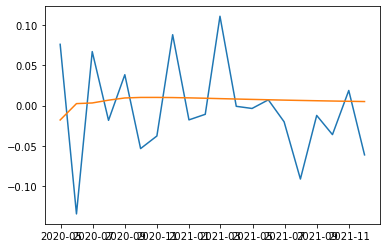

In [51]:
VARmodel = VAR(train_data).fit(maxlags=12, ic='aic')
VARmodel.summary()
lag_order = VARmodel.k_ar
VAR_forecasts=pd.DataFrame(VARmodel.forecast(train_data.values[-lag_order:],20))
VAR_forecasts.rename(columns={0:'HKPI_F'
# ,1:'infl_f',2:'10yr_f',3:'unemp_f'
},inplace=True)
test_data_new=pd.concat([test_data.reset_index(),VAR_forecasts],axis=1)
test_data_new.set_index('Date',inplace=True)
plt.plot(test_data_new['HKPI'],label='Actual')
plt.plot(test_data_new['HKPI_F'],label='Forecast')
plt.show()

In [50]:
# VAR(train_data).select_order(maxlags=12).summary()

In [250]:
VARmodel = VAR(train_data).fit(maxlags=12, ic='aic')
VARmodel.summary()

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 20, Feb, 2022
Time:                     12:21:17
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -28.9269
Nobs:                     304.000    HQIC:                  -29.3304
Log likelihood:           2397.32    FPE:                1.39705e-13
AIC:                     -29.5994    Det(Omega_mle):     1.16958e-13
--------------------------------------------------------------------
Results for equation HKPI
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              1.262383         1.564449            0.807           0.420
L1.HKPI            0.025315         0.062467            0.405           0.685
L1.infl            0.658033         0.749674            0.878           0

Based on the VAR(2) model, we did an impulse analysis. The graph below shows how a std unit shock to 5-year bond yields will affect the HKPI. We could see that the house price will immediately grow in about 2 months and will gradually drop down in the next period.

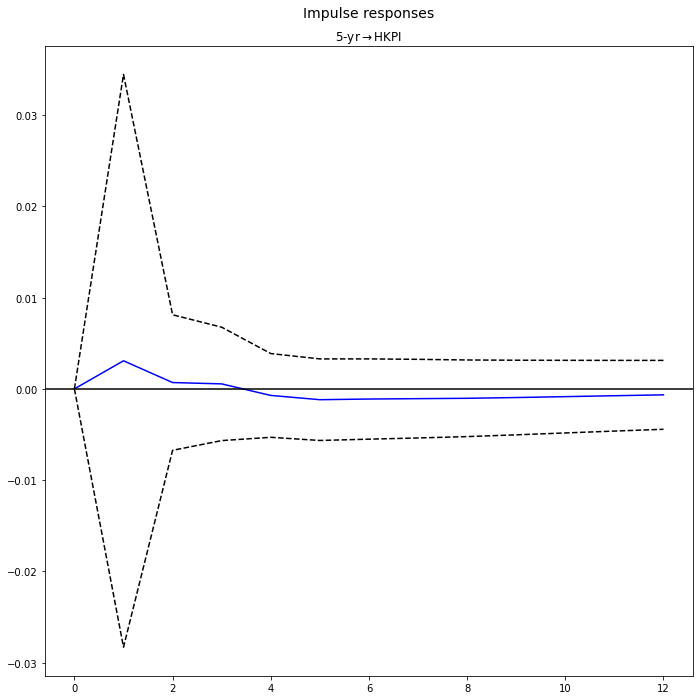

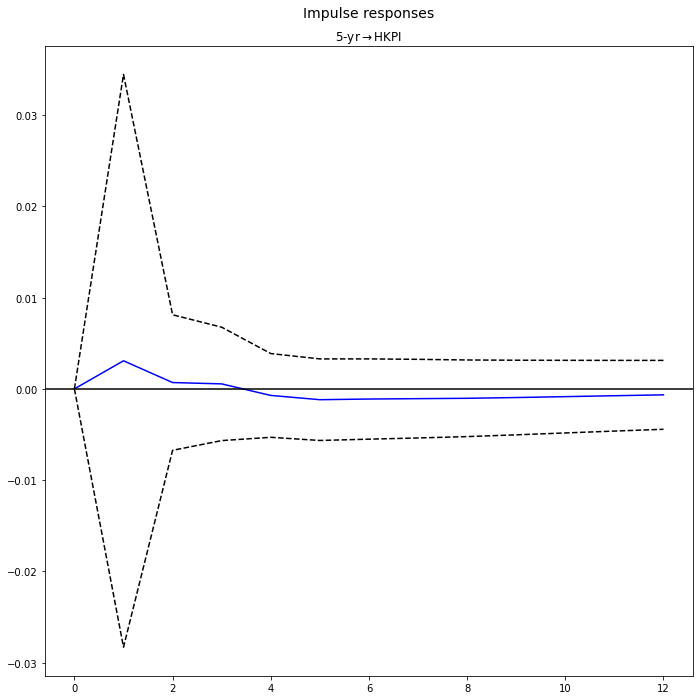

In [58]:
plt.rc("figure", figsize=(9,6))
# plt.rc("font", size=10)
irf = VARmodel.irf(12)
irf.plot(impulse='5-yr',response='HKPI')

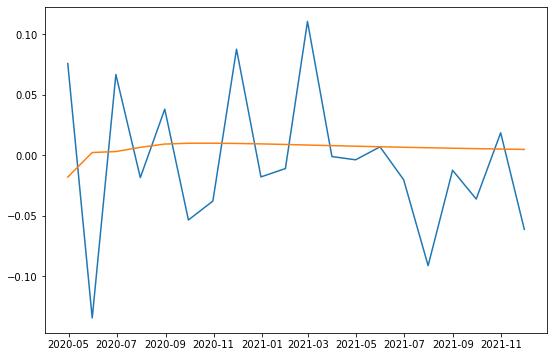

In [65]:
# Now we could do 24-month forecast to see how the house price will grow
lag_order = VARmodel.k_ar
oos_forecasts=pd.DataFrame(VARmodel.forecast(train_data.values[-lag_order:],24))
oos_forecasts.rename(columns={0:'HKPI'
# ,1:'infl_f',2:'10yr_f',3:'unemp_f'
},inplace=True)
test_data_new=pd.concat([test_data.reset_index(),VAR_forecasts],axis=1)
test_data_new.set_index('Date',inplace=True)
plt.plot(test_data_new['HKPI'],label='Actual')
plt.plot(test_data_new['HKPI_F'],label='Forecast')
plt.show()

In [62]:
MSE(test_data_new['HKPI'],test_data_new['HKPI_F'])

0.003692532079999524

The forecast of the growth in Hong Kong property prices ΔHKPI for the 24-month period at the end of the sample (11/30/2021) is shown below. We could see that the house price will drop in the end of year 2021 and will bounce sharply on Jan,2022. And then it will drop down to its lowest on March, 2022 and slowly increase in the future.

In [63]:
from datetime import *
t = date(2021, 11, 30) 
lst = []
for i in range(24):
    t = t + timedelta(days = 30)
    lst.append(t)
oos_forecasts.index = lst
oos = oos_forecasts['HKPI']
oos

2021-12-30   -0.007123
2022-01-29    0.006673
2022-02-28    0.002074
2022-03-30   -0.000849
2022-04-29   -0.001255
2022-05-29   -0.001233
2022-06-28   -0.001220
2022-07-28   -0.001136
2022-08-27   -0.000996
2022-09-26   -0.000842
2022-10-26   -0.000688
2022-11-25   -0.000540
2022-12-25   -0.000401
2023-01-24   -0.000274
2023-02-23   -0.000157
2023-03-25   -0.000052
2023-04-24    0.000042
2023-05-24    0.000126
2023-06-23    0.000201
2023-07-23    0.000267
2023-08-22    0.000326
2023-09-21    0.000377
2023-10-21    0.000422
2023-11-20    0.000460
Name: HKPI, dtype: float64

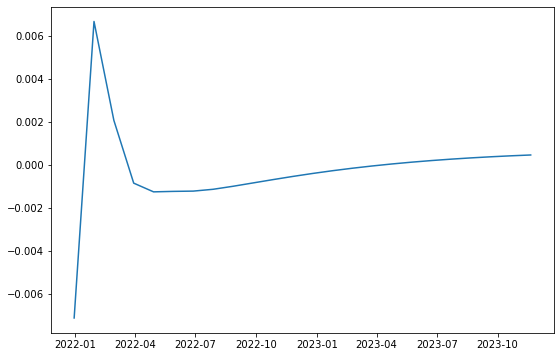

In [64]:
plt.plot(oos,label='Forecast')
plt.show()

## Model with mortgage

You could see that the VAR(2) still tend to predict the mean of the test data, so I need to find more variables. Here I use  the approved but not yet drawn mortgage as out new variable. We think it will help us to predict property index since the development of real estate is significantly driven by the demand side. No one nowadays would buy an estate without applying for the loan and in fact the volume of the new approved loan reflects government’s attitude towards the property market. 

In [321]:
# depo = pd.read_excel('C:\VSProject\data\depo.xls',sheet_name='Data').drop(columns=['Unnamed: 0'])
# depo.index = pd.to_datetime(depo['Date'])
# depo

In [322]:
# mort1 = pd.read_excel("C:\VSProject\data\mortgage.xlsx",sheet_name='Sheet1').dropna(axis = 0)
# from datetime import datetime
# mort1["year"] = pd.to_datetime(mort1['year'],format = '%Y').dt.year
# # mort1["month"][:246]=mort1["month"][:246].apply(lambda x : datetime.strptime(str(x), "%b").month)
# # mort1["month"][246:]=mort1["month"][246:].apply(lambda x : datetime.strptime(str(x), "%B").month)
# mort1

In [66]:
model_data = pd.read_excel('C:\VSProject\Forecasting\old.xlsx')
model_data.index = pd.to_datetime(model_data['Date'])
model_data.drop(columns=['Date'],inplace=True)
model_data

,HKPI,infl,5-yr,unemp,excrate,loan
Date,,,,,,
1996-01-31,0.184593,0.001080,5.850,3.5,7.7325,11109.000000
1996-02-29,-0.048984,0.010741,6.340,3.5,7.7315,10696.000000
1996-03-31,-0.011676,0.005328,6.840,3.0,7.7348,8102.000000
1996-04-30,0.020679,0.011622,7.130,3.0,7.7360,9958.000000
1996-05-31,0.049919,0.002099,7.350,3.0,7.7370,11517.000000
...,...,...,...,...,...,...
2021-07-31,-0.091059,0.000987,0.472,5.0,7.7720,39228.000000
2021-08-31,-0.012312,0.000986,0.538,4.7,7.7773,41363.526316
2021-09-30,-0.036057,-0.022921,0.710,4.5,7.7859,41318.869806


In [67]:
train_data= model_data.iloc[:-20,:]
test_data = model_data.iloc[-20:,:]
test_data

,HKPI,infl,5-yr,unemp,excrate,loan
Date,,,,,,
2020-04-30,0.075764,0.002692,0.322,5.2,7.7517,33302.000000
2020-05-31,-0.134264,-0.004490,0.558,5.9,7.7532,31535.000000
2020-06-30,0.066755,-0.000900,0.371,6.2,7.7505,32796.000000
2020-07-31,-0.018367,-0.025549,0.188,6.1,7.7502,33256.000000
2020-08-31,0.038136,0.020129,0.342,6.1,7.7501,34152.000000
2020-09-30,-0.053359,-0.018282,0.235,6.4,7.7496,35076.000000
2020-10-31,-0.037753,0.022801,0.279,6.4,7.7516,47161.000000
2020-11-30,0.087674,0.000000,0.352,6.3,7.7516,46413.000000
2020-12-31,-0.017800,-0.001805,0.385,6.6,7.7523,50967.000000


In [68]:
VARmodel = VAR(train_data).fit(maxlags=12, ic='aic')

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  warnings.warn('No frequency information was'


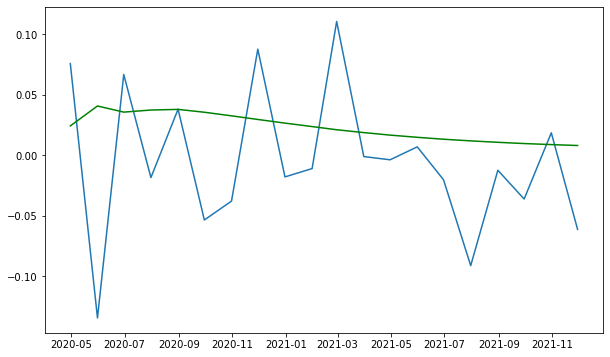

In [69]:
lag_order = VARmodel.k_ar
VAR_forecasts=pd.DataFrame(VARmodel.forecast(train_data.values[-lag_order:],20))
VAR_forecasts.rename(columns={0:'HKPI_F'
# ,1:'infl_f',2:'10yr_f',3:'unemp_f'
},inplace=True)
test_data_new=pd.concat([test_data.reset_index(),VAR_forecasts],axis=1)
test_data_new.set_index('Date',inplace=True)
plt.rc("figure", figsize=(10,6))
plt.plot(test_data_new['HKPI'],label='Actual')
plt.plot(test_data_new['HKPI_F'],label='Forecast',color = 'g')
plt.show()


In [363]:
oos = pd.DataFrame(VARmodel.forecast(model_data.values[-2:],24))
oos.rename(columns={0:'HKPI_F'
# ,1:'infl_f',2:'10yr_f',3:'unemp_f'
},inplace=True)

We can see that the forecasted trend is almost the same. And if we compare the actual digits, we could find out that the new variable helps to change the level of the index. All in all, I wouldn’t say this variable help improve the model too much but it did reveal something.

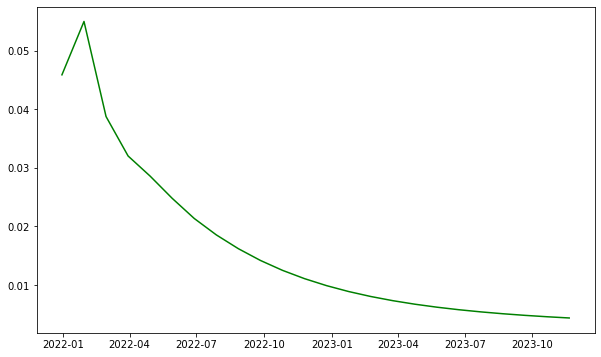

In [383]:
from datetime import *
t = date(2021, 11, 30) 
lst = []
for i in range(24):
    t = t + timedelta(days = 30)
    lst.append(t)
oos.index = lst
plt.plot(oos['HKPI_F'],label='Forecast',color = 'g')
plt.show()